In [5]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import normalize
import os
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import glob
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from scipy import ndimage

In [1]:
class Unet:

    '''Class to build a unet model and use it on a dataset'''

    def __init__(self,image_size,channels,classes) -> None:
        self.IMG_SIZE = image_size
        self.IMG_CHANNELS = channels
        self.classes = classes
        self.input_shape = (self.IMG_SIZE,self.IMG_SIZE,self.IMG_CHANNELS)
    
    def encoderBlock(self, input_layer,filters):
        c1 = Conv2D(filters,3,activation='relu',padding="same",input_shape=input_layer.shape)(input_layer)
        c2 = Conv2D(filters,3,activation='relu',padding="same",input_shape=input_layer.shape)(c1)
        m1 = MaxPooling2D(pool_size=2,padding='valid')(c2)
        return m1,c2
    
    def decoderBlock(self,input_layer,filters,skip):
        t1 = Conv2DTranspose(filters,(2,2),strides=2, padding='valid')(input_layer)
        t1 = Concatenate()([t1,skip])
        c1 = Conv2D(filters,3,activation='relu',padding="same")(t1)
        c2 = Conv2D(filters,3,activation='relu',padding="same")(c1)
        return c2
    
    def build_unet(self):

        Input_layer = Input(shape=self.input_shape)
        block1,skip1 = self.encoderBlock(Input_layer,64)
        block2,skip2 = self.encoderBlock(block1,128)
        block3,skip3 = self.encoderBlock(block2,256)
        block4,skip4 = self.encoderBlock(block3,512)

        final_encoder_block = Conv2D(1024,3,activation='relu',padding='same')(Conv2D(1024,3,activation='relu',padding='same')(block4))

        block5 = self.decoderBlock(final_encoder_block,512,skip4)
        block6 = self.decoderBlock(block5,256,skip3)
        block7 = self.decoderBlock(block6,128,skip2)
        block8 = self.decoderBlock(block7,64,skip1)

        if self.classes==1:
            self.activation="sigmoid"
        else:
            self.activation="softmax"

        output = Conv2D(filters=self.classes,kernel_size=1,activation=self.activation,padding='same')(block8)
        self.model = Model(Input_layer,output,name="U-Net")

In [6]:
IMG_SIZE = 256
channels = 3
classes = 1
AUTOTUNE = tf.data.AUTOTUNE
unet = Unet(IMG_SIZE,channels,classes)
unet.build_unet()
model_definition = unet.model

In [10]:
class Pipeline:
    def __init__(self,img_dir,mask_dir,batch_size,model_definition):
        self.image_directory = img_dir
        self.mask_directory = mask_dir
        self.rng = tf.random.Generator.from_seed(123, alg='philox')
        self.batch_size = batch_size
        self.model = model_definition

    def fetch_names(self):
        self.image_names = glob.glob("{image_directory}*.jpg".format(image_directory=self.image_directory))
        self.image_names.sort()
        self.mask_names = glob.glob("{mask_directory}*.jpg".format(mask_directory=self.mask_directory))
        self.mask_names.sort()

    def read_names(self):
        self.images = [cv2.imread(img, 1) for img in self.image_names]
        self.masks = [cv2.imread(mask, 0) for mask in self.mask_names]

    def resize(self):
        for i in range(len(self.images)):
            self.images[i] = cv2.resize(self.images[i],(IMG_SIZE,IMG_SIZE))
            self.masks[i] = cv2.resize(self.masks[i],(IMG_SIZE,IMG_SIZE))

    def prepare_shape(self):
        self.images = np.array(self.images)
        self.masks = np.array(self.masks)
        self.masks = np.expand_dims(self.masks, axis = 3)
    
    def threshold_masks(self):
        self.masks = np.where(self.masks >= 128, 255, 0)
    
    def display_random_pair(self):
        random_index = np.random.randint(0,len(self.images)-1)
        cv2_img = cv2.cvtColor(self.images[random_index], cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(12, 6))
        plt.subplot(121)
        plt.imshow(cv2_img)
        plt.subplot(122)
        plt.imshow(self.masks[random_index],cmap='grey')
        plt.show()

    def random_rotate_scipy(self,image,label):
        angle = np.random.uniform(-180,180)
        image = ndimage.rotate(image,angle,reshape = False)
        label = ndimage.rotate(label,angle,reshape = False)
        image = tf.cast(image, tf.float32)
        label = tf.cast(label, tf.float32)
        return image,label
    
    def resize_and_rescale(self,image):
        image = tf.cast(image, tf.float32)
        image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
        image = (image / 255.0)
        return image
    
    def augment(self,image_label,seed):

        image, label = image_label
        
        image = self.resize_and_rescale(image)
        label = self.resize_and_rescale(label)
        
        image = tf.image.stateless_random_crop(value=image,size=(IMG_SIZE,IMG_SIZE,3),seed=seed)
        label = tf.image.stateless_random_crop(value=label,size=(IMG_SIZE,IMG_SIZE,1),seed=seed)

        image = tf.image.stateless_random_flip_left_right(image,seed=seed)
        label = tf.image.stateless_random_flip_left_right(label,seed=seed)

        image = tf.image.stateless_random_flip_up_down(image,seed=seed)
        label = tf.image.stateless_random_flip_up_down(label,seed=seed)
        
        # [-max_delta, max_delta]
        image = tf.image.stateless_random_brightness(image,max_delta=0.2,seed=seed)

        # Random rotate image and label
        image,label = tf.py_function(self.random_rotate_scipy,inp=[image, label], Tout=(tf.float32,tf.float32))
        image.set_shape((IMG_SIZE,IMG_SIZE,3))
        label.set_shape((IMG_SIZE,IMG_SIZE,1))

        # [1.0 - lower, 1.0 + upper]
        image = tf.image.stateless_random_contrast(image,lower=0.2,upper=0.5,seed=seed)

        return image, label
    
    def f(self,x, y):
        seed = self.rng.make_seeds(2)[0]
        image, label = self.augment((x,y),seed)
        return image, label
    
    def prepare_dataset(self):
        
        X_train, X_test, y_train, y_test = train_test_split(self.images, self.masks, test_size = 0.1, random_state = 42)
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)
        
        self.train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
        self.test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
        self.validation_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))

    def augment_dataset(self):

        self.train_ds = (
            self.train_dataset
            .shuffle(50)
            .repeat(20)
            .map(self.f, num_parallel_calls=tf.data.AUTOTUNE)
            .batch(self.batch_size)
            .prefetch(tf.data.AUTOTUNE)
        )

        self.test_ds = (
            self.test_dataset
            .shuffle(50)
            .repeat(20)
            .map(self.f, num_parallel_calls=tf.data.AUTOTUNE)
            .batch(self.batch_size)
            .prefetch(tf.data.AUTOTUNE)
        )

        self.val_ds = (
            self.validation_dataset
            .shuffle(50)
            .repeat(20)
            .map(self.f, num_parallel_calls=tf.data.AUTOTUNE)
            .batch(self.batch_size)
            .prefetch(tf.data.AUTOTUNE)
        )

    def train(self,lr,epochs):
        self.model.compile(loss='binary_crossentropy',optimizer=Adam(learning_rate=lr),metrics=['accuracy'])
        return self.model.fit(self.train_ds,verbose=1,epochs=epochs,validation_data=self.val_ds)

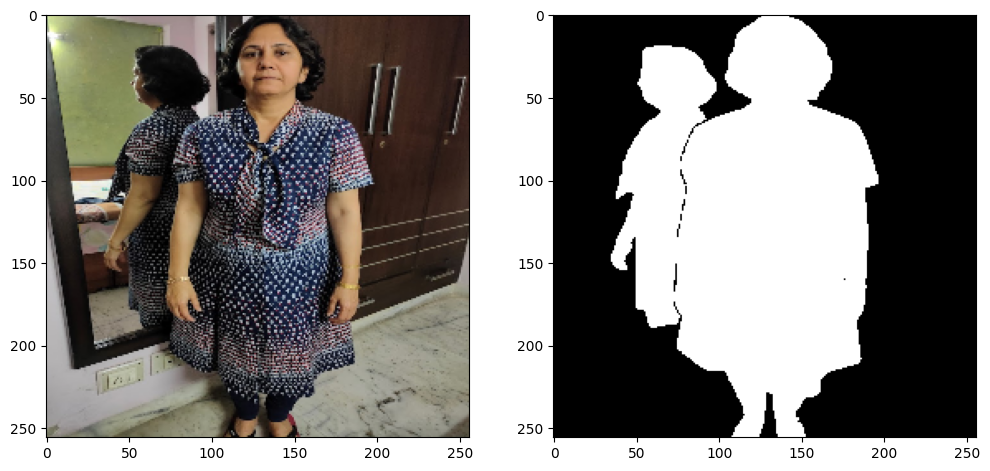

In [11]:
img_dir = './segmentation_images/'
mask_dir = './segmentation_masks/'
lr = 1e-3
epochs = 1
batch_size = 10

p = Pipeline(img_dir,mask_dir,batch_size,model_definition)
p.fetch_names()
p.read_names()
p.resize()
p.prepare_shape()
p.threshold_masks()
p.display_random_pair()
p.prepare_dataset()
p.augment_dataset()

In [12]:
history = p.train(lr,epochs)

 8/94 [=>............................] - ETA: 31:05 - loss: 0.4524 - accuracy: 0.5061

KeyboardInterrupt: 

In [10]:
history